# Connecting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing Dependencies


In [ ]:
!pip install facenet_pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.7 MB/s 


In [ ]:
cd /content/drive/My Drive/FYP_BRO/Face_Recognition

/content/drive/My Drive/FYP_BRO/Face_Recognition


In [ ]:
cd C:\Users\Hannan Ghani\Downloads\Fyp

[Errno 2] No such file or directory: 'C:UsersHannan GhaniDownloadsFyp'
/content/drive/My Drive/FYP_BRO/Face_Recognition


#Getting Embeddings

In [ ]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
import os
import model as embedding
import torch
import pickle

from facenet_pytorch import MTCNN
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# face detection model
mtcnn = MTCNN(image_size=160)

# load embedding model
embedder = embedding.InceptionResnetV1(pretrained='vggface2').eval()

# paths to save pickle files
currentDir = os.getcwd()

# images folder
dataset = "/content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects"

# paths to save pickle files
embeddingPickle = os.path.join(currentDir, "output/FinalEmbeddings.pickle")

# getting all images paths
imagePaths = list(paths.list_images(dataset))

In [ ]:
print("Total number of images ", len(imagePaths))

Total number of images  249


In [ ]:
# create lists to append ImgPaths/names/imageIDs/boxs/embeddings
ImgPaths = []
names = []
imageIDs = []
boxs = []
embeddings = []

# initlize the total number of faces processed
total = 0

In [ ]:
# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
    
    #extract the person name from the image path
    
    name = imagePath.split(os.path.sep)[-2]
    imageID = imagePath.split(os.path.sep)[-1].split('.')[-2]
    
    image = Image.open(imagePath)
    try:
        img_cropped = mtcnn.detect(image)
        box = img_cropped[0][0]
        box = box.astype('int')
    
        face = mtcnn(image)
    except:
        print("[Error] : ", imagePath)
    
    faceEmbed = embedder(face.unsqueeze(0))
    flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
    
    ImgPaths.append(imagePath)
    imageIDs.append(imageID)
    names.append(name)
    boxs.append(box)
    embeddings.append(flattenEmbed)
    total += 1

# dump the facial embeddings + names to disk
print("[INFO] serializing {} encodings ....".format(total))
data = {"paths":ImgPaths, "names":names, "imageIDs":imageIDs, "boxs":boxs, "embeddings":embeddings}
f = open(embeddingPickle , "wb")
f.write(pickle.dumps(data))
f.close()

[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Urooba/Subject_1_0002.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Urooba/Subject_1_0001.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Urooba/Subject_1_0003.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Urooba/Subject_1_0004.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/rabi/Subject_3_0002.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/rabi/Subject_3_0008.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Sheryar Ali/20191211_191231.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Sheryar Ali/20191211_191149.png
[Error] :  /content/drive/My Drive/FYP_BRO/RecognitionTest/2nd phase subjects/Sheryar Ali/20191211_182414.png
[Error] :  /content/drive/My Drive/FYP_BRO/Recogni

# Train Recognition Model

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import pickle
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

In [ ]:
# paths to embedding pickle file
embeddingPickle = "./output/FinalEmbeddings.pickle"

# path to recognizer pickle file
recognizerPickle = "./output/FinalRecognizer.pickle"

# path to labels pickle file
labelPickle = "./output/FinalLabel.pickle"

In [ ]:
# loading embeddings pickle
data = pickle.loads(open(embeddingPickle, "rb").read())

# encode the labels
label = LabelEncoder()
labels = label.fit_transform(data["names"])

# getting embeddings
Embeddings = np.array(data["embeddings"])

In [ ]:
print("Total number of embeddings : ", Embeddings.shape)
print("Total number of labels :", len(labels))

Total number of embeddings :  (249, 512)
Total number of labels : 249


## Hyper-parameter tuning

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    Embeddings, labels, test_size=0.2, random_state=0)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(199, 512)
(50, 512)
(199,)
(50,)


## SVC

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

In [ ]:
scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'kernel': 'linear'}

Grid scores on development set:

0.027 (+/-0.054) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.027 (+/-0.054) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.027 (+/-0.054) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.027 (+/-0.054) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.616 (+/-0.095) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.027 (+/-0.054) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.965 (+/-0.050) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.616 (+/-0.095) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.959 (+/-0.051) for {'C': 1, 'kernel': 'linear'}
0.985 (+/-0.019) for {'C': 10, 'kernel': 'linear'}
0.985 (+/-0.019) for {'C': 100, 'kernel': 'linear'}
0.985 (+/-0.019) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model is trained on the full development set.
The scores are computed on the full ev

In [ ]:
# train the model used to accept the 512-d embeddings of the face and 
# then produce the actual face recognition

#recognizer = KNeighborsClassifier(n_neighbors= 5, metric='euclidean', weights="distance")
recognizer = SVC(probability=True , C=1000, gamma=0.001 , kernel='rbf')
recognizer.fit(Embeddings, labels)

# write the actual face recognition model to disk
f = open(recognizerPickle, "wb")
f.write(pickle.dumps(recognizer))
f.close()

# write the label encoder to disk
f = open(labelPickle,"wb")
f.write(pickle.dumps(label))
f.close()

# Recognize

In [ ]:
import numpy as np
import pickle
import cv2
import os
import model as embedding
from imutils import paths
import imutils
import argparse
import torch

import os
import argparse
import torch
import numpy as np
import torch.backends.cudnn as cudnn

from models.retinaface.config import cfg
from models.retinaface.prior_box import PriorBox
from models.retinaface.py_cpu_nms import py_cpu_nms

import cv2

from models.retinaface.retinaface import RetinaFace
from models.retinaface.box_utils import decode , decode_landm
import time

                    
import torchvision.transforms.functional as F
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# paths to embedding pickle file
embeddingPickle = "./output/FinalEmbeddings.pickle"

# path to recognizer pickle file
recognizerPickle = "./output/FinalRecognizer.pickle"

# path to labels pickle file
labelPickle = "./output/FinalLabel.pickle"

predictedImg = "./predictedImg"

In [ ]:
trained_model_path = "models/retinaface/weights/Final_Retinaface.pth"
cpu = False
confidence_threshold = 0.02
top_k = 5000
nms_threshold = 0.3
keep_top_k = 750
save_image_path = "predictedImg"
vis_threshold = 0.5

In [ ]:
### check_keys

def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

### remove_prefix
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}


### load_model
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [ ]:
torch.set_grad_enabled(False)

#net and model
net = RetinaFace(phase="test")
net = load_model(net , trained_model_path, cpu)
net.eval()
print("Finished loading model!")
cudnn.benchmark = True
device = torch.device("cpu" if cpu else "cuda")
net = net.to(device)

Loading pretrained model from models/retinaface/weights/Final_Retinaface.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!


In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.get_device_name(0)

'Tesla T4'

In [ ]:
torch.cuda.is_available()

True

In [ ]:
resize = 1

In [ ]:
# load embedding model
embedder = embedding.InceptionResnetV1(pretrained="vggface2").eval()

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open(recognizerPickle, "rb").read())
label = pickle.loads(open(labelPickle, "rb").read())
# loading embeddings pickle
data = pickle.loads(open(embeddingPickle, "rb").read())

COLORS = np.random.randint(0, 255, size=(len(label.classes_), 3), dtype="uint8")

In [ ]:
labels = label.fit_transform(data["names"])

In [ ]:
Embeddings = np.array(data["embeddings"])
names = np.array(data["names"])
print("Embeddings ", Embeddings.shape)
print("Names ", names.shape)
print("Labels ", labels.shape)

Embeddings  (249, 512)
Names  (249,)
Labels  (249,)


In [ ]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

In [ ]:
image_path = "1.jpg"
save_image = True

In [ ]:
import os, pandas as pd
from PIL import Image
import matplotlib

In [ ]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

import os

In [ ]:
def predictclass(path):
    from PIL import Image
    from PIL import ImageFont
    from PIL import ImageDraw
    import os
    image_path = path
    img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

    imageName = image_path.split('/')[-1].split('.')[-2]

    img = np.float32(img_raw)

    im_height, im_width, _ = img.shape
    scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
    img -= (104, 117, 123)
    img = img.transpose(2, 0, 1)
    img = torch.from_numpy(img).unsqueeze(0)
    img = img.to(device)
    scale = scale.to(device)

    tic = time.time()
    loc, conf, landms = net(img)  # forward pass
    print('net forward time: {:.4f}'.format(time.time() - tic))

    priorbox = PriorBox(cfg, image_size=(im_height, im_width))
    priors = priorbox.forward()
    priors = priors.to(device)
    prior_data = priors.data
    boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
    boxes = boxes * scale / resize
    boxes = boxes.cpu().numpy()
    scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
    landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
    scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                   img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                   img.shape[3], img.shape[2]])
    scale1 = scale1.to(device)
    landms = landms * scale1 / resize
    landms = landms.cpu().numpy()

    # ignore low scores
    inds = np.where(scores > confidence_threshold)[0]
    boxes = boxes[inds]
    landms = landms[inds]
    scores = scores[inds]

    # keep top-K before NMS
    order = scores.argsort()[::-1][:top_k]
    boxes = boxes[order]
    landms = landms[order]
    scores = scores[order]

    # do NMS
    dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
    keep = py_cpu_nms(dets, nms_threshold)
    # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
    dets = dets[keep, :]
    landms = landms[keep]

    # keep top-K faster NMS
    dets = dets[:keep_top_k, :]
    landms = landms[:keep_top_k, :]

    dets = np.concatenate((dets, landms), axis=1)
    #############################
    faces_counter=0
    frame_number=0
    result = {}
    faces_info = {}
    faces_name = {}
    face_state = {}
    Attentive=0
    Inattentive=0
    textx=im_width/2
    texty=im_height/2
    #######################

    # show image
    if save_image:
                for b in dets:
                    faces_counter= faces_counter+1
                    if b[4] < vis_threshold:
                        continue
                    boxes = np.array(b[0:4])
                    boxes = boxes.astype('int')
                    #attempt to save detected faces to a csv file
                    frame_number += 1
              
                    ###############################
                    (startX , startY, endX, endY) = boxes

                    face = img_raw_rgb[startY:endY , startX:endX]

                    try:
                        #print("yes-1")
                        faceRead = Image.fromarray(face)
                        faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                        faceRead = F.to_tensor(faceRead)
                        #print("yes-2")
                    except:
                        print("[Error] - resizing face ")
                        continue
                    #print(faceRead.shape)

                    # getting embeddings for croped faces
                    faceEmbed = embedder(faceRead.unsqueeze(0))
                    flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                    #print(flattenEmbed.shape)

                    # predicting class
                    array = np.array(flattenEmbed).reshape(1,-1)
                    # perform classification to recognize the face
                    preds = recognizer.predict_proba(array)[0]
                    face_image = cv2.resize(face, (64,64))
                    face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                    face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                    j = np.argmax(preds)
                    a= np.argmax(model.predict(face_image))
                    label_map = dict((v,k) for k,v in emotion_dict.items()) 
                    proba = preds[j]
                    name = label.classes_[j]
                    emotion = label_map[a]
                    att='Attentive'
                    inatt='Inattentive'
                    if (a=='Attentive'):
                      Attentive+=1
                    elif (a=='Inattentive'):
                      Inattentive+=1


                    #print(name)

                    result = np.where(names == name)
                    resultEmbeddings = Embeddings[result]

                    dists = []
                    for emb in resultEmbeddings:
                        d = distance(emb, flattenEmbed)
                        dists.append(d)
                    #print(dists)
                    distarray = np.array(dists)
                    #print(distarray)
                    min_dist = np.min(distarray)
                    max_dist = np.max(distarray)
                    #print("Name : ",name)
                    #print("min dist : ",min_dist)
                    #print("max dist : ", max_dist)
                    
                    if proba >= 0.15:

                        if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                            #print("dist name ", name)
                            #print("min dist : ",min_dist)
                            #print("max dist : ", max_dist)


                            #color = [int(c) for c in COLORS[j]]
                            color = (0, 255, 0)
                            cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                            #text = "{}: {:.2f}".format(name, proba)
                            #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                            text = "{}/{}".format(name, emotion)

                            cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                            ###########################
                            if (emotion=='Attentive'):
                              Attentive+=1
                            elif (emotion=='Inattentive'):
                              Inattentive+=1                    
                            faces_name[faces_counter] = name + ' : '+ emotion
                            face_state[faces_counter] = emotion
                            #########################

                        else:

                            name = "NONE"

                            color = (255, 255, 255)

                            cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                            text = "{}".format(emotion)
                            #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                            #text = "{}/{}".format(name, emotion)
                            #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                            #####################
                            if (emotion=='Attentive'):
                              Attentive+=1
                            elif (emotion=='Inattentive'):
                              Inattentive+=1                    

                            faces_name[faces_counter] = name + ' : '+ emotion
                            face_state[faces_counter] = emotion
                            ####################

                    else:

                        name = "NONE"

                        color = (255, 255, 255)

                        cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                        text = "{}".format(emotion)
                        #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                        #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                        #####################
                        if (emotion=='Attentive'):
                          Attentive+=1
                        elif (emotion=='Inattentive'):
                          Inattentive+=1                   

                        faces_name[faces_counter] = name + ' : '+ emotion
                        face_state[faces_counter] = emotion
                        #tems[face_counter]= name + emotion
                        ####################                        
    Total_faces=Attentive+Inattentive
    Total_faces=str(Total_faces)
    Attentive=str(Attentive)
    Inattentive=str(Inattentive)
    strr='Total Faces Detected:'+Total_faces+'\n'+'Attentive'+':'+Attentive+'Inattentive'+':'+Inattentive

    # save image predict folder
    font = cv2.FONT_HERSHEY_COMPLEX
    #cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
    #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
    df.to_csv(imageName+'.csv',index = False)
    ######################
    #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
    im = Image.open("{}/{}.png".format(predictedImg,imageName))
    


    
    #draw = ImageDraw.Draw(im)
    #font = ImageFont.truetype(<font-file>, <font-size>)
    #font = ImageFont.truetype("sans-serif.ttf", 16)
    #draw.text((x, y),"Sample Text",(r,g,b))
    #draw.text((5, 15),strr,(255,255,255),font=font)
    #im.save('sample-out.jpg')
    
    #plt.imshow(img_raw)
    #plt.show()
    return im              
               

In [ ]:
predictclass("/content/20190529_110904.jpg")

net forward time: 0.0086


net forward time: 1.8642


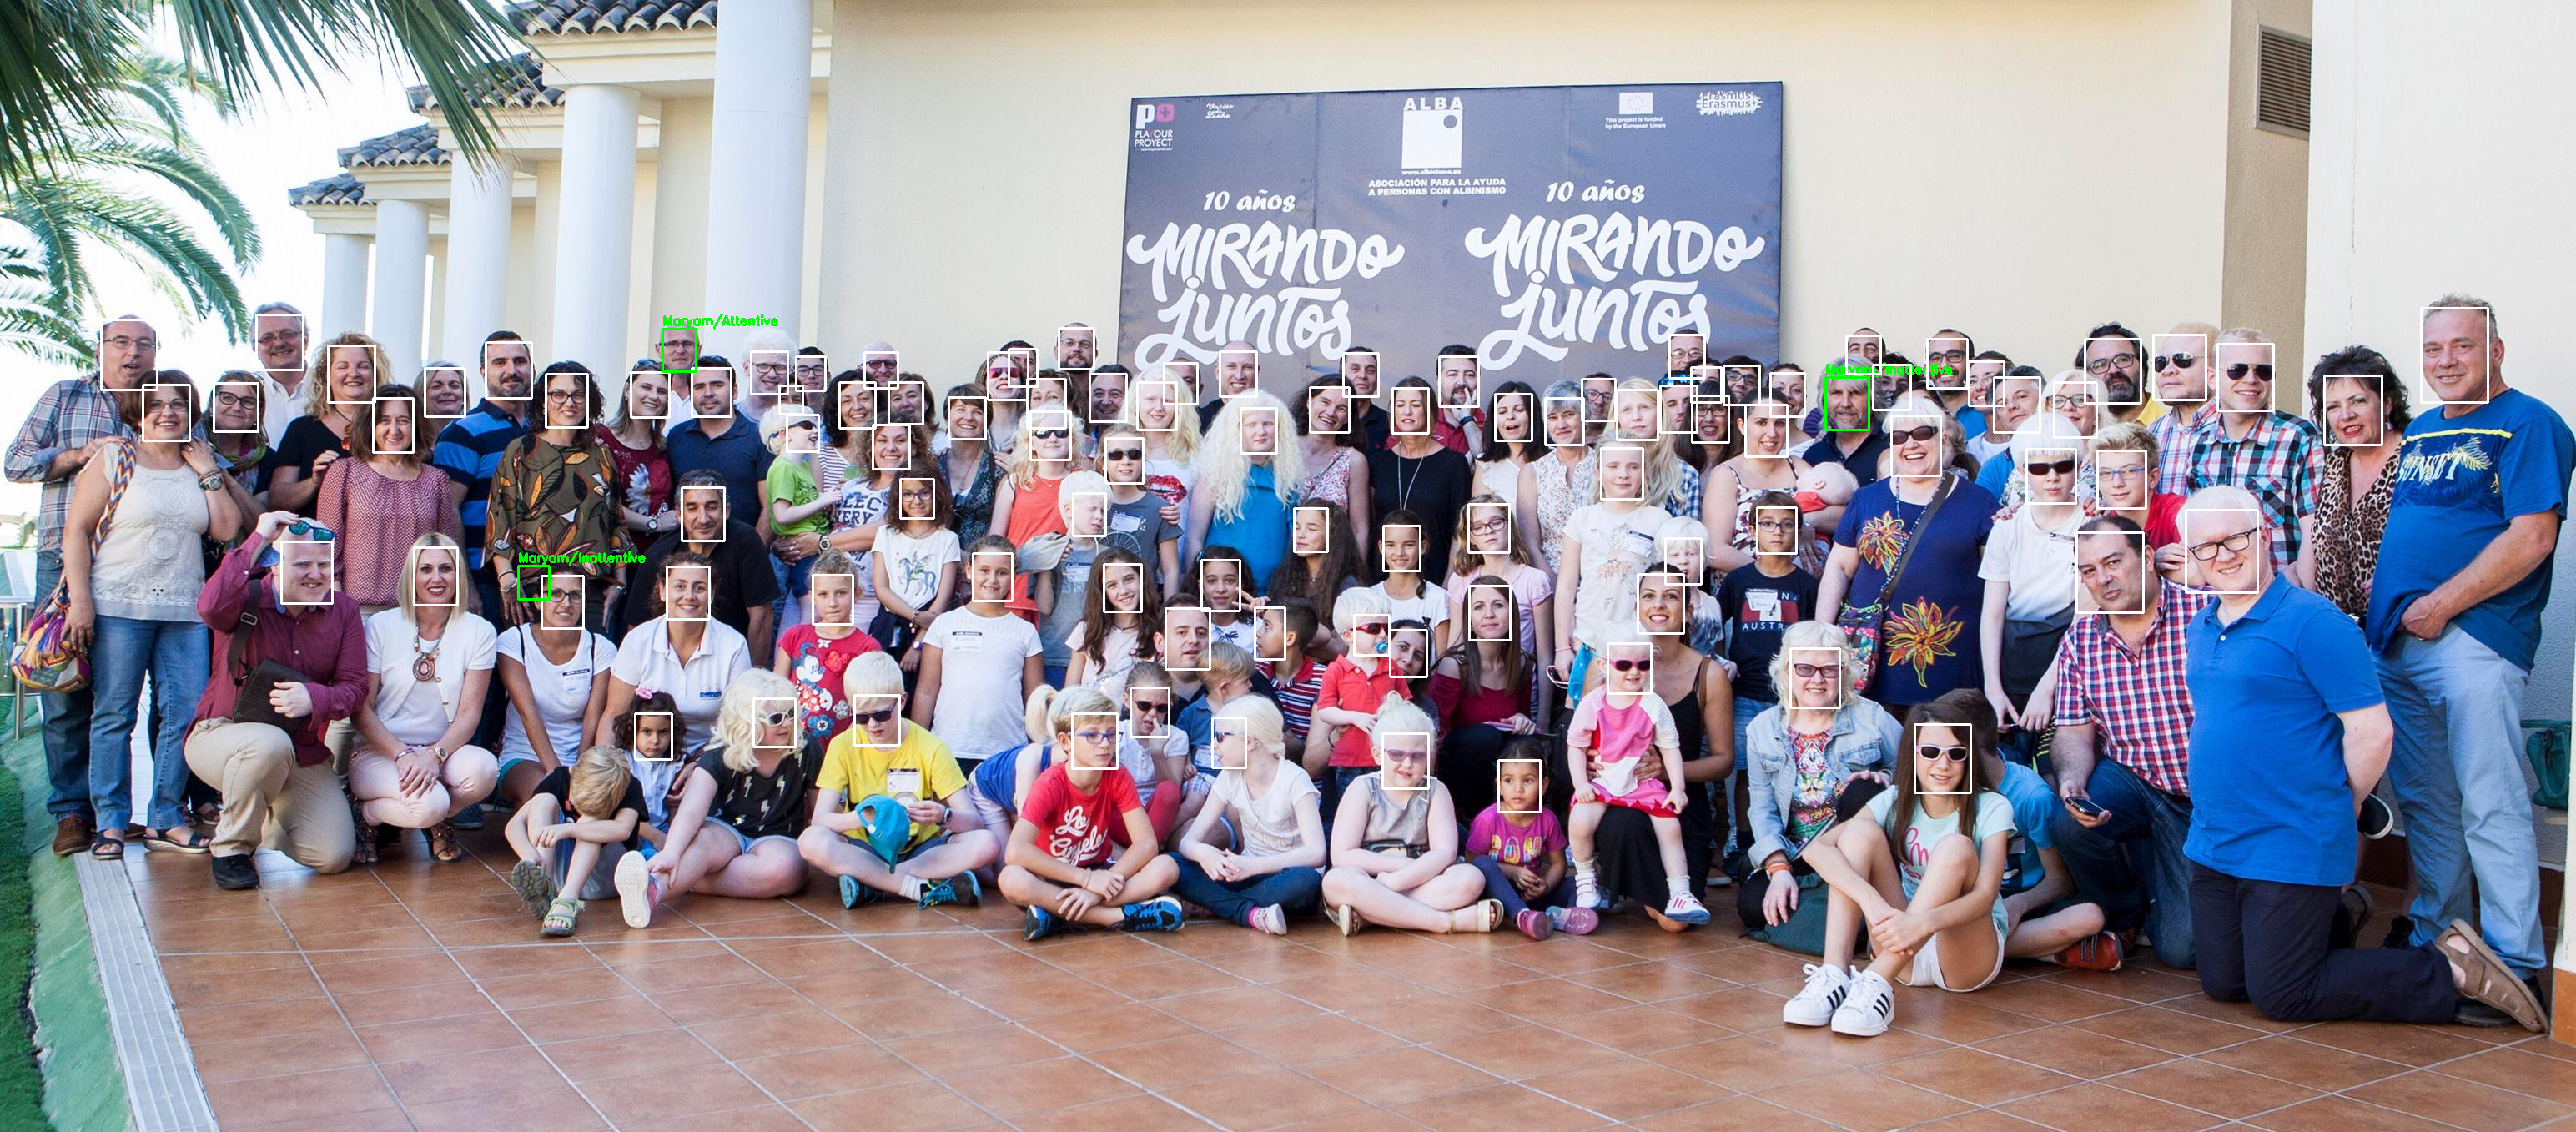

In [ ]:
predictclass('/content/drive/My Drive/FYP_BRO/Face_Recognition/testImg/group.jpg')

In [ ]:
predictclass("C:/Users/Hannan Ghani/Downloads/Fyp/testImg/group.jpg")

# Emotion Recognition

In [ ]:
torch.device("cpu")

device(type='cpu')

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
emotion_dict= {'Attentive': 0, 'Inattentive': 1}

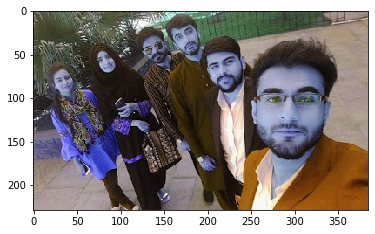

In [ ]:
face_image  = cv2.imread("testImg/mates.jpg")
plt.imshow(face_image)

In [ ]:
print (face_image.shape)

(229, 385, 3)


In [ ]:
face_image = cv2.resize(face_image, (64,64))
face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])

In [ ]:
from keras.models import load_model

Using TensorFlow backend.


In [ ]:
model = load_model("/content/drive/My Drive/FYP_BRO/AttentiveInattentiveModel/my_model.hdf5")

In [ ]:
model = load_model("my_model.hdf5")

In [ ]:
predicted_class = np.argmax(model.predict(face_image))

In [ ]:
label_map = dict((v,k) for k,v in emotion_dict.items()) 
predicted_label = label_map[predicted_class]

In [ ]:

print(predicted_label)

Inattentive


# Experiment

In [ ]:
model_json_file="/content/drive/My Drive/FYP_BRO/AttentiveInattentiveModel/modelxception.json"
model_weights_file="/content/drive/My Drive/FYP_BRO/AttentiveInattentiveModel/modelxception.h5"

In [ ]:
with open(model_json_file, "r") as json_file:
    loaded_model_json = json_file.read()
    loaded_model = model_from_json(loaded_model_json)

loaded_model.load_weights(model_weights_file)
print("Model loaded from disk")
loaded_model.summary()


In [ ]:
model.save('/content/sample_data/myyyy_model.hdf5') 


In [ ]:
load_model("/content/sample_data/myyyy_model.hdf5")

In [ ]:
model.summary()

# Finalization On video

In [ ]:
fps=24

In [ ]:
import numpy as np
import cv2

In [ ]:
cap = cv2.VideoCapture(0)

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, 1)

    # Display the resulting frameQ
    cv2.imshow('frame',gray)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

In [ ]:
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))


In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
import cv2
import numpy as np

# Create a VideoCapture object
cap = cv2.VideoCapture(0)

# Check if camera opened successfully
if (cap.isOpened() == False): 
  print("Unable to read camera feed")

# Default resolutions of the frame are obtained.The default resolutions are system dependent.
# We convert the resolutions from float to integer.
frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

# Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
out = cv2.VideoWriter('outpy.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
while(True):
  ret, frame = cap.read()
  frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)

  if ret == True: 
    
    # Write the frame into the file 'output.avi'
    out.write(frame)

    # Display the resulting frame    
    cv2.imshow('frame',frame)

    # Press Q on keyboard to stop recording
    if cv2.waitKey(1) & 0xFF == ord('q'):
      break

  # Break the loop
  else:
    break  

# When everything done, release the video capture and video write objects
cap.release()
out.release()

# Closes all the frames
cv2.destroyAllWindows() 

In [ ]:
    from PIL import Image
    from PIL import ImageFont
    from PIL import ImageDraw
    import os

In [ ]:
def vid(path):
    cap = cv2.VideoCapture(path)
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    name=path+'.avi'
    # Define the codec and create VideoWriter object.The output is stored in 'outpy.avi' file.
    out = cv2.VideoWriter(name,cv2.VideoWriter_fourcc('M','J','P','G'), 10, (frame_width,frame_height))
    #while cap.isOpened():
    while (cap.isOpened()):
        ret, frame = cap.read()
        if not ret:
            print("Can't receive frame (stream end?). Exiting ...")
            break
        image_path = path

        img_raw = frame
        img_raw_rgb = cv2.cvtColor(frame, 1)
        #img_raw_rgb = frame
        imageName = image_path.split('/')[-1].split('.')[-2]

        img = np.float32(img_raw)

        im_height, im_width, _ = img.shape
        scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
        img -= (104, 117, 123)
        img = img.transpose(2, 0, 1)
        img = torch.from_numpy(img).unsqueeze(0)
        img = img.to(device)
        scale = scale.to(device)

        tic = time.time()
        loc, conf, landms = net(img)  # forward pass
        print('net forward time: {:.4f}'.format(time.time() - tic))

        priorbox = PriorBox(cfg, image_size=(im_height, im_width))
        priors = priorbox.forward()
        priors = priors.to(device)
        prior_data = priors.data
        boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
        boxes = boxes * scale / resize
        boxes = boxes.cpu().numpy()
        scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
        landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
        scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                       img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                       img.shape[3], img.shape[2]])
        scale1 = scale1.to(device)
        landms = landms * scale1 / resize
        landms = landms.cpu().numpy()

        # ignore low scores
        inds = np.where(scores > confidence_threshold)[0]
        boxes = boxes[inds]
        landms = landms[inds]
        scores = scores[inds]

        # keep top-K before NMS
        order = scores.argsort()[::-1][:top_k]
        boxes = boxes[order]
        landms = landms[order]
        scores = scores[order]

        # do NMS
        dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
        keep = py_cpu_nms(dets, nms_threshold)
        # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
        dets = dets[keep, :]
        landms = landms[keep]

        # keep top-K faster NMS
        dets = dets[:keep_top_k, :]
        landms = landms[:keep_top_k, :]

        dets = np.concatenate((dets, landms), axis=1)
        #############################
        faces_counter=0
        frame_number=0
        result = {}
        faces_info = {}
        faces_name = {}
        face_state = {}
        Attentive=0
        Inattentive=0
        textx=im_width/2
        texty=im_height/2
        #######################

        # show image
        if save_image:
                    for b in dets:
                        faces_counter= faces_counter+1
                        if b[4] < vis_threshold:
                            continue
                        boxes = np.array(b[0:4])
                        boxes = boxes.astype('int')
                        #attempt to save detected faces to a csv file
                        frame_number += 1

                        ###############################
                        (startX , startY, endX, endY) = boxes

                        face = img_raw_rgb[startY:endY , startX:endX]

                        try:
                            #print("yes-1")
                            faceRead = Image.fromarray(face)
                            faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                            faceRead = F.to_tensor(faceRead)
                            #print("yes-2")
                        except:
                            print("[Error] - resizing face ")
                            continue
                        #print(faceRead.shape)

                        # getting embeddings for croped faces
                        faceEmbed = embedder(faceRead.unsqueeze(0))
                        flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                        #print(flattenEmbed.shape)

                        # predicting class
                        array = np.array(flattenEmbed).reshape(1,-1)
                        # perform classification to recognize the face
                        preds = recognizer.predict_proba(array)[0]
                        face_image = cv2.resize(face, (64,64))
                        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                        face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                        j = np.argmax(preds)
                        a= np.argmax(model.predict(face_image))
                        label_map = dict((v,k) for k,v in emotion_dict.items()) 
                        proba = preds[j]
                        name = label.classes_[j]
                        emotion = label_map[a]
                        att='Attentive'
                        inatt='Inattentive'
                        if (a=='Attentive'):
                          Attentive+=1
                        elif (a=='Inattentive'):
                          Inattentive+=1


                        #print(name)

                        result = np.where(names == name)
                        resultEmbeddings = Embeddings[result]

                        dists = []
                        for emb in resultEmbeddings:
                            d = distance(emb, flattenEmbed)
                            dists.append(d)
                        #print(dists)
                        distarray = np.array(dists)
                        #print(distarray)
                        min_dist = np.min(distarray)
                        max_dist = np.max(distarray)
                        #print("Name : ",name)
                        #print("min dist : ",min_dist)
                        #print("max dist : ", max_dist)

                        if proba >= 0.15:

                            if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                                #print("dist name ", name)
                                #print("min dist : ",min_dist)
                                #print("max dist : ", max_dist)


                                #color = [int(c) for c in COLORS[j]]
                                color = (0, 255, 0)
                                cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                                #text = "{}: {:.2f}".format(name, proba)
                                #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                                text = "{}/{}".format(name, emotion)

                                #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                                ###########################
                                if (emotion=='Attentive'):
                                  Attentive+=1
                                elif (emotion=='Inattentive'):
                                  Inattentive+=1                    
                                faces_name[faces_counter] = name + ' : '+ emotion
                                face_state[faces_counter] = emotion
                                #########################

                            else:

                                name = "NONE"

                                color = (255, 255, 255)

                                cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                                text = "{}".format(emotion)
                                #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                                #text = "{}/{}".format(name, emotion)
                                #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                                #####################
                                if (emotion=='Attentive'):
                                  Attentive+=1
                                elif (emotion=='Inattentive'):
                                  Inattentive+=1                    

                                faces_name[faces_counter] = name + ' : '+ emotion
                                face_state[faces_counter] = emotion
                                ####################

                        else:

                            name = "NONE"

                            color = (255, 255, 255)

                            cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                            text = "{}".format(emotion)
                            #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                            #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                            #####################
                            if (emotion=='Attentive'):
                              Attentive+=1
                            elif (emotion=='Inattentive'):
                              Inattentive+=1                   

                            faces_name[faces_counter] = name + ' : '+ emotion
                            face_state[faces_counter] = emotion
                            #tems[face_counter]= name + emotion
                            out.write(img_raw)
                            if cv2.waitKey(1) & 0xFF == ord('q'):
                              break
                            

        out.write(img_raw)

        # Display the resulting frame    
        #cv2.imshow('frame',img_raw)

        # Press Q on keyboard to stop recording
        if cv2.waitKey(1) & 0xFF == ord('q'):
          break                        ####################                        
    Total_faces=Attentive+Inattentive
    Total_faces=str(Total_faces)
    Attentive=str(Attentive)
    Inattentive=str(Inattentive)
    strr='Total Faces Detected:'+Total_faces+'\n'+'Attentive'+'\U0001F610 😀'+Attentive+'Inattentive'+'\U0001F614'+Inattentive

    # save image predict folder
    #font = cv2.FONT_HERSHEY_COMPLEX
    #cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
    #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
    df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
    df.to_csv(imageName+'.csv',index = False)
    ######################
    #cv2.imshow(img_raw)
    #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
#    cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)

#    im = Image.open("{}/{}.png".format(predictedImg,imageName))


    
    #draw = ImageDraw.Draw(im)
    #font = ImageFont.truetype(<font-file>, <font-size>)
    #font = ImageFont.truetype("sans-serif.ttf", 16)
    #draw.text((x, y),"Sample Text",(r,g,b))
    #draw.text((5, 15),strr,(255,255,255),font=font)
    #im.save('sample-out.jpg')
    
    #plt.imshow(img_raw)
    #plt.show()
    return im              
               

In [ ]:
vid('Test.mp4')

net forward time: 4.3520
net forward time: 4.2210
net forward time: 4.1320
net forward time: 5.7490
net forward time: 5.3220
net forward time: 6.5150
net forward time: 5.6070
net forward time: 3.8829
net forward time: 4.0199
net forward time: 4.5064
net forward time: 5.2084
net forward time: 4.9470
net forward time: 3.8097
net forward time: 4.3700
net forward time: 4.6406
net forward time: 4.0034
net forward time: 3.8938
net forward time: 3.9630
net forward time: 3.7703
net forward time: 5.1650
net forward time: 5.4458
net forward time: 4.1860
[Error] - resizing face 
net forward time: 4.2330
[Error] - resizing face 
net forward time: 4.0580
net forward time: 3.9796
net forward time: 3.8890
net forward time: 4.1180
[Error] - resizing face 
net forward time: 4.1454
[Error] - resizing face 
net forward time: 4.4027
[Error] - resizing face 
net forward time: 4.6963
net forward time: 4.0964
net forward time: 4.4915
net forward time: 4.7256
net forward time: 4.1676
net forward time: 4.5184


TypeError: ignored

In [ ]:
!git clone https://github.com/intel-iot-devkit/sample-videos.git

fatal: destination path 'sample-videos' already exists and is not an empty directory.


In [ ]:
def predictvideo(path):
    cap = cv2.VideoCapture(path)
    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter('output.avi',fourcc, 20.0, (640,480))

    #cap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    #image_path = path
    ###############################
    faces_counter=0
    frame_number=0
    result = {}
    faces_info = {}
    faces_name = {}
    face_state = {}
    ###############################
    while(cap.isOpened()):
      # Capture frame-by-frame
      ret, frame = cap.read()
      image_path = frame
      #frame = cv2.imread(frame)
      frame = frame[:, :, ::-1]
      # Our operations on the frame come here
      #img_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
      #gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
      img_raw = frame
      img_raw_rgb = cv2.cvtColor(img_raw, 1)
      ###############################
      frame_number += 1
      faces_info = {}
        # to track number of faces in a single frame
      faces_counter = 0
      ###############################
      #img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
      #img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB) 
      #cap = cv2.VideoCapture(os.path.abspath(args.source) 
      #cap.set(cv2.CAP_PROP_FPS, int(fps))
      #_, fr = cap.read()
      #imageName = image_path.split('/')[-1].split('.')[-2]

      img = np.float32(img_raw)

      im_height, im_width, _ = img.shape
      scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
      img -= (104, 117, 123)
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).unsqueeze(0)
      img = img.to(device)
      scale = scale.to(device)

      tic = time.time()
      loc, conf, landms = net(img)  # forward pass
      print('net forward time: {:.4f}'.format(time.time() - tic))

      priorbox = PriorBox(cfg, image_size=(im_height, im_width))
      priors = priorbox.forward()
      priors = priors.to(device)
      prior_data = priors.data
      boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
      boxes = boxes * scale / resize
      boxes = boxes.cpu().numpy()
      scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
      landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
      scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2]])
      scale1 = scale1.to(device)
      landms = landms * scale1 / resize
      landms = landms.cpu().numpy()

      # ignore low scores
      inds = np.where(scores > confidence_threshold)[0]
      boxes = boxes[inds]
      landms = landms[inds]
      scores = scores[inds]

      # keep top-K before NMS
      order = scores.argsort()[::-1][:top_k]
      boxes = boxes[order]
      landms = landms[order]
      scores = scores[order]

      # do NMS
      dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
      keep = py_cpu_nms(dets, nms_threshold)
      # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
      dets = dets[keep, :]
      landms = landms[keep]

      # keep top-K faster NMS
      dets = dets[:keep_top_k, :]
      landms = landms[:keep_top_k, :]

      dets = np.concatenate((dets, landms), axis=1)

      # show image
      if save_image:
      
                  for b in dets:
                      if b[4] < vis_threshold:
                          continue
                      boxes = np.array(b[0:4])
                      boxes = boxes.astype('int')
                      #startX = int(startX )
                      #startY = int(startY)
                      #endX   =int(endX)
                      #endY   =int(endY)
                      (startX , startY, endX, endY) = boxes
                      startX = int(startX )
                      startY = int(startY)
                      endX   =int(endX)
                      endY   =int(endY)                        
                      face = img_raw_rgb[startY:endY , startX:endX]
                        
                      try:
                          #print("yes-1")
                          faceRead = Image.fromarray(face)
                          faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                          faceRead = F.to_tensor(faceRead)
                          #print("yes-2")
                      except:
                          print("[Error] - resizing face ")
                          continue
                      #print(faceRead.shape)

                      # getting embeddings for croped faces
                      faceEmbed = embedder(faceRead.unsqueeze(0))
                      flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                      #print(flattenEmbed.shape)

                      # predicting class
                      array = np.array(flattenEmbed).reshape(1,-1)
                      # perform classification to recognize the face
                      preds = recognizer.predict_proba(array)[0]
                      face_image = cv2.resize(face, (64,64))
                      face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                      face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                      j = np.argmax(preds)
                      aaa= np.argmax(model.predict(face_image))
                      label_map = dict((v,k) for k,v in emotion_dict.items()) 
                      proba = preds[j]
                      name = label.classes_[j]
                      emotion = label_map[aaa]
                      #print(name)

                      result = np.where(names == name)
                      resultEmbeddings = Embeddings[result]

                      dists = []
                      for emb in resultEmbeddings:
                          d = distance(emb, flattenEmbed)
                          dists.append(d)
                      #print(dists)
                      distarray = np.array(dists)
                      #print(distarray)
                      min_dist = np.min(distarray)
                      max_dist = np.max(distarray)
                      #print("Name : ",name)
                      #print("min dist : ",min_dist)
                      #print("max dist : ", max_dist)
                      
                      if proba >= 0:

                          if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.40):

                              #print("dist name ", name)
                              #print("min dist : ",min_dist)
                              #print("max dist : ", max_dist)


                              #color = [int(c) for c in COLORS[j]]
                              color = (0, 255, 0)
                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)
                              faces_info[faces_counter] = name+" : "+emotion
                              faces_counter += 1
                              #text = "{}: {:.2f}".format(name, proba)
                              text = "{}/{}".format(name, emotion)
                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

                          else:

                              name = "NONE"

                              color = (255, 255, 255)

                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)
                              faces_info[faces_counter] = name+" : "+emotion
                              faces_counter += 1

                              text = "{}".format(emotion)
                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                      #else:

                          #name = "NONE"

                          #color = (255, 255, 255)

                          #cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)
                          #cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)
                          #faces_info[faces_counter] = name+" : "+emotion
                          #faces_counter += 1

                          #text = "{}".format(emotion)
                          #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


      # save image predicted foler
      
      #frame = cv2.flip(frame,0)

        # write the flipped frame
      out.write(frame)
      cv2.imshow('frame',frame)
      result[frame_number] = faces_info
      if cv2.waitKey(1) & 0xFF == ord('q'):
        break      
    df = pd.DataFrame(faces_info.items(),columns = ['frame_number','face_info'])
    df.to_csv('resultsss.csv',index = False)
    cap.release()
    out.release()
    cv2.destroyAllWindows()
      #cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
      #im = Image.open("{}/{}.png".format(predictedImg,imageName))
      #return im                
      

In [ ]:
predictvideo(0)

# TAKING FRAMES FROM CLASS VIDEO AND ANALYZING THEM

In [ ]:
cd /content/drive/My Drive/FYP_BRO/Face_Recognition

/content/drive/My Drive/FYP_BRO/Face_Recognition


In [ ]:
videoFile='/content/drive/My Drive/FYP_BRO/Face_Recognition/sample-videos/classroom.mp4'

In [ ]:
import cv2

In [ ]:
import cv2

cap = cv2.VideoCapture(videoFile)
count = 0

while cap.isOpened():
    ret, frame = cap.read()

    if ret:
        cv2.imwrite('ExtractedFrames/frame{:d}.jpg'.format(count), frame)
        print("EXTRACTED FRAME",count)
        count += 30 # i.e. at 30 fps, this advances one second
        cap.set(1, count)
    else:
        cap.release()
        break

EXTRACTED FRAME 0
EXTRACTED FRAME 30
EXTRACTED FRAME 60
EXTRACTED FRAME 90
EXTRACTED FRAME 120
EXTRACTED FRAME 150
EXTRACTED FRAME 180
EXTRACTED FRAME 210
EXTRACTED FRAME 240
EXTRACTED FRAME 270
EXTRACTED FRAME 300
EXTRACTED FRAME 330
EXTRACTED FRAME 360
EXTRACTED FRAME 390
EXTRACTED FRAME 420
EXTRACTED FRAME 450
EXTRACTED FRAME 480
EXTRACTED FRAME 510
EXTRACTED FRAME 540
EXTRACTED FRAME 570
EXTRACTED FRAME 600
EXTRACTED FRAME 630
EXTRACTED FRAME 660
EXTRACTED FRAME 690
EXTRACTED FRAME 720
EXTRACTED FRAME 750
EXTRACTED FRAME 780
EXTRACTED FRAME 810
EXTRACTED FRAME 840
EXTRACTED FRAME 870
EXTRACTED FRAME 900
EXTRACTED FRAME 930
EXTRACTED FRAME 960


In [ ]:

from google.colab.patches import cv2_imshow
for img in glob.glob("/content/drive/My Drive/FYP_BRO/Face_Recognition/ExtractedFrames/*.jpg"):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    im = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
    cv2_imshow(im)

In [ ]:
predictclass('/content/drive/My Drive/FYP_BRO/Face_Recognition/ExtractedFrames')

In [ ]:
cd /content/drive/My Drive/FYP_BRO/Face_Recognition

/content/drive/My Drive/FYP_BRO/Face_Recognition


In [ ]:
def predictclass(path):

    cap = cv2.VideoCapture(videoFile)
    count = 0

    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            cv2.imwrite('ExtractedFrames/frame{:d}.jpg'.format(count), frame)
            print("EXTRACTED FRAME",count)
            count += 30 # i.e. at 30 fps, this advances one second
            cap.set(1, count)
        else:
            cap.release()
            break
    from PIL import Image
    from PIL import ImageFont
    from PIL import ImageDraw
    import os
    fldr=path+'/*.jpg'
    for images in glob.glob("/content/drive/My Drive/FYP_BRO/Face_Recognition/ExtractedFrames/*.jpg"):
      image_path = images
      img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

      imageName = image_path.split('/')[-1].split('.')[-2]

      img = np.float32(img_raw)

      im_height, im_width, _ = img.shape
      scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
      img -= (104, 117, 123)
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).unsqueeze(0)
      img = img.to(device)
      scale = scale.to(device)

      tic = time.time()
      loc, conf, landms = net(img)  # forward pass
      print('net forward time: {:.4f}'.format(time.time() - tic))

      priorbox = PriorBox(cfg, image_size=(im_height, im_width))
      priors = priorbox.forward()
      priors = priors.to(device)
      prior_data = priors.data
      boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
      boxes = boxes * scale / resize
      boxes = boxes.cpu().numpy()
      scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
      landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
      scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2]])
      scale1 = scale1.to(device)
      landms = landms * scale1 / resize
      landms = landms.cpu().numpy()

      # ignore low scores
      inds = np.where(scores > confidence_threshold)[0]
      boxes = boxes[inds]
      landms = landms[inds]
      scores = scores[inds]

      # keep top-K before NMS
      order = scores.argsort()[::-1][:top_k]
      boxes = boxes[order]
      landms = landms[order]
      scores = scores[order]

      # do NMS
      dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
      keep = py_cpu_nms(dets, nms_threshold)
      # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
      dets = dets[keep, :]
      landms = landms[keep]

      # keep top-K faster NMS
      dets = dets[:keep_top_k, :]
      landms = landms[:keep_top_k, :]

      dets = np.concatenate((dets, landms), axis=1)
      #############################
      faces_counter=0
      frame_number=0
      result = {}
      faces_info = {}
      faces_name = {}
      face_state = {}
      Attentive=0
      Inattentive=0
      textx=im_width/2
      texty=im_height/2
      #######################

      # show image
      if save_image:
                  for b in dets:
                      faces_counter= faces_counter+1
                      if b[4] < vis_threshold:
                          continue
                      boxes = np.array(b[0:4])
                      boxes = boxes.astype('int')
                      #attempt to save detected faces to a csv file
                      frame_number += 1
                
                      ###############################
                      (startX , startY, endX, endY) = boxes

                      face = img_raw_rgb[startY:endY , startX:endX]

                      try:
                          #print("yes-1")
                          faceRead = Image.fromarray(face)
                          faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                          faceRead = F.to_tensor(faceRead)
                          #print("yes-2")
                      except:
                          print("[Error] - resizing face ")
                          continue
                      #print(faceRead.shape)

                      # getting embeddings for croped faces
                      faceEmbed = embedder(faceRead.unsqueeze(0))
                      flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                      #print(flattenEmbed.shape)

                      # predicting class
                      array = np.array(flattenEmbed).reshape(1,-1)
                      # perform classification to recognize the face
                      preds = recognizer.predict_proba(array)[0]
                      face_image = cv2.resize(face, (64,64))
                      face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                      face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                      j = np.argmax(preds)
                      a= np.argmax(model.predict(face_image))
                      label_map = dict((v,k) for k,v in emotion_dict.items()) 
                      proba = preds[j]
                      name = label.classes_[j]
                      emotion = label_map[a]
                      att='Attentive'
                      inatt='Inattentive'
                      if (a=='Attentive'):
                        Attentive+=1
                      elif (a=='Inattentive'):
                        Inattentive+=1


                      #print(name)

                      result = np.where(names == name)
                      resultEmbeddings = Embeddings[result]

                      dists = []
                      for emb in resultEmbeddings:
                          d = distance(emb, flattenEmbed)
                          dists.append(d)
                      #print(dists)
                      distarray = np.array(dists)
                      #print(distarray)
                      min_dist = np.min(distarray)
                      max_dist = np.max(distarray)
                      #print("Name : ",name)
                      #print("min dist : ",min_dist)
                      #print("max dist : ", max_dist)
                      
                      if proba >= 0.15:

                          if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                              #print("dist name ", name)
                              #print("min dist : ",min_dist)
                              #print("max dist : ", max_dist)


                              #color = [int(c) for c in COLORS[j]]
                              color = (0, 255, 0)
                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              #text = "{}: {:.2f}".format(name, proba)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              text = "{}/{}".format(name, emotion)

                              #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              ###########################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1                    
                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              #########################

                          else:

                              name = "NONE"

                              color = (255, 255, 255)

                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              text = "{}".format(emotion)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)
                              #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              #####################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1                    

                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              ####################

                      else:

                          name = "NONE"

                          color = (255, 255, 255)

                          cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                          text = "{}".format(emotion)
                          #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                          #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                          #####################
                          if (emotion=='Attentive'):
                            Attentive+=1
                          elif (emotion=='Inattentive'):
                            Inattentive+=1                   

                          faces_name[faces_counter] = name + ' : '+ emotion
                          face_state[faces_counter] = emotion
                          #tems[face_counter]= name + emotion
                          ####################                        
      Total_faces=Attentive+Inattentive
      Total_faces=str(Total_faces)
      Attentive=str(Attentive)
      Inattentive=str(Inattentive)
      strr='Total Faces Detected:'+Total_faces+'\n'+'Attentive :'+Attentive+'Inattentive :'+Inattentive

      # save image predict folder
      font = cv2.FONT_HERSHEY_COMPLEX
      cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
      #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
      df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
      csvfolder='CSV/'
      filename=imageName+'.csv'
      df.to_csv(csvfolder+filename,index = False)
      ######################
      #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
      cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
      im = Image.open("{}/{}.png".format(predictedImg,imageName))
      cv2_imshow(img_raw)


      
      #draw = ImageDraw.Draw(im)
      #font = ImageFont.truetype(<font-file>, <font-size>)
      #font = ImageFont.truetype("sans-serif.ttf", 16)
      #draw.text((x, y),"Sample Text",(r,g,b))
      #draw.text((5, 15),strr,(255,255,255),font=font)
      #im.save('sample-out.jpg')
      
      #plt.imshow(img_raw)
      #plt.show()
    return 0             
                

# TAKING FRAMES AND PRODUCING FINALIZED CSV

In [ ]:
import cv2
import glob
import os, pandas as pd

In [ ]:
def predictclass(path):

    cap = cv2.VideoCapture(path)
    count = 0
    Total_Frames=0
    attentivecount=0
    inattentivecount=0
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            cv2.imwrite('ExtractedFrames/frame{:d}.jpg'.format(count), frame)
            print("EXTRACTED FRAME",count)
            count += 30 # i.e. at 30 fps, this advances one second
            Total_Frames+=1
            cap.set(1, count)
        else:
            cap.release()
            break

   # fldr=path+'/*.jpg'
    print(Total_Frames)
    for images in glob.glob("ExtractedFrames/*.jpg"):
      image_path = images
      img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

      imageName = image_path.split('/')[-1].split('.')[-2]

      img = np.float32(img_raw)

      im_height, im_width, _ = img.shape
      scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
      img -= (104, 117, 123)
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).unsqueeze(0)
      img = img.to(device)
      scale = scale.to(device)

      tic = time.time()
      loc, conf, landms = net(img)  # forward pass
      print('net forward time: {:.4f}'.format(time.time() - tic))

      priorbox = PriorBox(cfg, image_size=(im_height, im_width))
      priors = priorbox.forward()
      priors = priors.to(device)
      prior_data = priors.data
      boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
      boxes = boxes * scale / resize
      boxes = boxes.cpu().numpy()
      scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
      landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
      scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2]])
      scale1 = scale1.to(device)
      landms = landms * scale1 / resize
      landms = landms.cpu().numpy()

      # ignore low scores
      inds = np.where(scores > confidence_threshold)[0]
      boxes = boxes[inds]
      landms = landms[inds]
      scores = scores[inds]

      # keep top-K before NMS
      order = scores.argsort()[::-1][:top_k]
      boxes = boxes[order]
      landms = landms[order]
      scores = scores[order]

      # do NMS
      dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
      keep = py_cpu_nms(dets, nms_threshold)
      # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
      dets = dets[keep, :]
      landms = landms[keep]

      # keep top-K faster NMS
      dets = dets[:keep_top_k, :]
      landms = landms[:keep_top_k, :]

      dets = np.concatenate((dets, landms), axis=1)
      #############################
      faces_counter=0
      frame_number=0
      result = {}
      faces_info = {}
      faces_name = {}
      face_state = {}
      Attentive=0
      Inattentive=0
      textx=im_width/2
      texty=im_height/2
      #######################

      # show image
      if save_image:
                  for b in dets:
                      faces_counter= faces_counter+1
                      if b[4] < vis_threshold:
                          continue
                      boxes = np.array(b[0:4])
                      boxes = boxes.astype('int')
                      #attempt to save detected faces to a csv file
                      frame_number += 1
                
                      ###############################
                      (startX , startY, endX, endY) = boxes

                      face = img_raw_rgb[startY:endY , startX:endX]

                      try:
                          #print("yes-1")
                          faceRead = Image.fromarray(face)
                          faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                          faceRead = F.to_tensor(faceRead)
                          #print("yes-2")
                      except:
                          print("[Error] - resizing face ")
                          continue
                      #print(faceRead.shape)

                      # getting embeddings for croped faces
                      faceEmbed = embedder(faceRead.unsqueeze(0))
                      flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                      #print(flattenEmbed.shape)

                      # predicting class
                      array = np.array(flattenEmbed).reshape(1,-1)
                      # perform classification to recognize the face
                      preds = recognizer.predict_proba(array)[0]
                      face_image = cv2.resize(face, (64,64))
                      face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                      face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                      j = np.argmax(preds)
                      a= np.argmax(model.predict(face_image))
                      label_map = dict((v,k) for k,v in emotion_dict.items()) 
                      proba = preds[j]
                      name = label.classes_[j]
                      emotion = label_map[a]
                      att='Attentive'
                      inatt='Inattentive'
                      if (a=='Attentive'):
                        Attentive+=1
                      elif (a=='Inattentive'):
                        Inattentive+=1


                      #print(name)

                      result = np.where(names == name)
                      resultEmbeddings = Embeddings[result]

                      dists = []
                      for emb in resultEmbeddings:
                          d = distance(emb, flattenEmbed)
                          dists.append(d)
                      #print(dists)
                      distarray = np.array(dists)
                      #print(distarray)
                      min_dist = np.min(distarray)
                      max_dist = np.max(distarray)
                      #print("Name : ",name)
                      #print("min dist : ",min_dist)
                      #print("max dist : ", max_dist)
                      
                      if proba >= 0.15:

                          if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                              #print("dist name ", name)
                              #print("min dist : ",min_dist)
                              #print("max dist : ", max_dist)


                              #color = [int(c) for c in COLORS[j]]
                              color = (0, 255, 0)
                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              #text = "{}: {:.2f}".format(name, proba)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              text = "{}/{}".format(name, emotion)

                              #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              ###########################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1
                                                  
                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              #########################

                          else:

                              name = "NONE"

                              color = (255, 255, 255)

                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              text = "{}".format(emotion)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)
                              #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              #####################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1                    

                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              ####################

                      else:

                          name = "NONE"

                          color = (255, 255, 255)

                          cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                          text = "{}".format(emotion)
                          #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                          #cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                          #####################
                          if (emotion=='Attentive'):
                            Attentive+=1
                          elif (emotion=='Inattentive'):
                            Inattentive+=1                   

                          faces_name[faces_counter] = name + ' : '+ emotion
                          face_state[faces_counter] = emotion
                          #tems[face_counter]= name + emotion
                          ####################                        
      Total_faces=Attentive+Inattentive
      attentivecount+=Attentive
      inattentivecount+=Inattentive
      
      T_f=str(Total_faces)
      Att=str(Attentive)
      Inatt=str(Inattentive)

      strr='Total Faces Detected:'+T_f+'\n'+'Attentive :'+Att+'Inattentive :'+Inatt

      # save image predict folder
      font = cv2.FONT_HERSHEY_COMPLEX
      cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
      #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
      df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
      csvfolder='CSV/'
      filename=imageName+'.csv'
      df.to_csv(csvfolder+filename,index = False)
      ######################
      #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
      cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
      im = Image.open("{}/{}.png".format(predictedImg,imageName))
      #cv2_imshow(img_raw)


      
      #draw = ImageDraw.Draw(im)
      #font = ImageFont.truetype(<font-file>, <font-size>)
      #font = ImageFont.truetype("sans-serif.ttf", 16)
      #draw.text((x, y),"Sample Text",(r,g,b))
      #draw.text((5, 15),strr,(255,255,255),font=font)
      #im.save('sample-out.jpg')
      
      #plt.imshow(img_raw)
      #plt.show()
    #TotalClassAttentivePercentage=0
    #TotalClassInattentivePercentage=0
    #a=int(TotalClassAttentivePercentage)
    #b=int(TotalClassInattentivePercentage)
    facescount=attentivecount+inattentivecount
    perc=(attentivecount/(attentivecount+inattentivecount))*100
    print(perc,'Total_Frames : ',Total_Frames,'Total Faces',facescount,'Attentive',attentivecount,'Inattentive',inattentivecount,(attentivecount/facescount)*100)
    facescount = float(facescount)
    attentivecount = float(attentivecount)
    inattentivecount = float(inattentivecount)
    TotalClassAttentivePercentage=(facescount/attentivecount)*100
    TotalClassInattentivePercentage=(facescount/inattentivecount)*100
    print('Attentive % : ',TotalClassAttentivePercentage,'Inattentive % : ',TotalClassInattentivePercentage)

    print('Attentive % : {0:.2f}%'.format((facescount / attentivecount * 100)))
    print('Inattentive % : {0:.2f}%'.format((facescount / inattentivecount * 100)))
    print(TotalClassAttentivePercentage)
    #print('a%',a,'i%',b)
    #df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
    #df.to_csv(csvfolder+filename,index = False)
    return facescount,attentivecount,inattentivecount   
          
                

In [ ]:
path='/content/drive/My Drive/FYP_BRO/Face_Recognition/sample-videos/20200219_143025.mp4'

In [ ]:
    cap = cv2.VideoCapture(path)
    count = 0
    Total_Frames=0
    attentivecount=0
    inattentivecount=0
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            cv2.imwrite('ExtractedFrames/frame{:d} {:d} seconds.jpg'.format(Total_Frames,count), frame)
            print("EXTRACTED FRAME",Total_Frames,"At ",count," seconds")
            count += 30 # i.e. at 30 fps, this advances one second
            Total_Frames+=1
            cap.set(1, count)
        else:
            cap.release()
            break
    
   # fldr=path+'/*.jpg'









    for images in glob.glob("ExtractedFrames/*.jpg"):
      image_path = images
      img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

      imageName = image_path.split('/')[-1].split('.')[-2]

      img = np.float32(img_raw)

      im_height, im_width, _ = img.shape
      scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
      img -= (104, 117, 123)
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).unsqueeze(0)
      img = img.to(device)
      scale = scale.to(device)

      tic = time.time()
      loc, conf, landms = net(img)  # forward pass
      print('net forward time: {:.4f}'.format(time.time() - tic))

      priorbox = PriorBox(cfg, image_size=(im_height, im_width))
      priors = priorbox.forward()
      priors = priors.to(device)
      prior_data = priors.data
      boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
      boxes = boxes * scale / resize
      boxes = boxes.cpu().numpy()
      scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
      landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
      scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2]])
      scale1 = scale1.to(device)
      landms = landms * scale1 / resize
      landms = landms.cpu().numpy()

      # ignore low scores
      inds = np.where(scores > confidence_threshold)[0]
      boxes = boxes[inds]
      landms = landms[inds]
      scores = scores[inds]

      # keep top-K before NMS
      order = scores.argsort()[::-1][:top_k]
      boxes = boxes[order]
      landms = landms[order]
      scores = scores[order]

      # do NMS
      dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
      keep = py_cpu_nms(dets, nms_threshold)
      # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
      dets = dets[keep, :]
      landms = landms[keep]

      # keep top-K faster NMS
      dets = dets[:keep_top_k, :]
      landms = landms[:keep_top_k, :]

      dets = np.concatenate((dets, landms), axis=1)
      #############################
      faces_counter=0
      frame_number=0
      result = {}
      faces_info = {}
      faces_name = {}
      face_state = {}
      no_of_faces_recognized=0
      Attentive=0
      Inattentive=0
      textx=im_width/2
      texty=im_height/2
      #######################

      # show image
      if save_image:
                  for b in dets:
                      faces_counter= faces_counter+1
                      if b[4] < vis_threshold:
                          continue
                      boxes = np.array(b[0:4])
                      boxes = boxes.astype('int')
                      #attempt to save detected faces to a csv file
                      frame_number += 1
                
                      ###############################
                      (startX , startY, endX, endY) = boxes

                      face = img_raw_rgb[startY:endY , startX:endX]

                      try:
                          #print("yes-1")
                          faceRead = Image.fromarray(face)
                          faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                          faceRead = F.to_tensor(faceRead)
                          #print("yes-2")
                      except:
                          print("[Error] - resizing face ")
                          continue
                      #print(faceRead.shape)

                      # getting embeddings for croped faces
                      faceEmbed = embedder(faceRead.unsqueeze(0))
                      flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                      #print(flattenEmbed.shape)

                      # predicting class
                      array = np.array(flattenEmbed).reshape(1,-1)
                      # perform classification to recognize the face
                      preds = recognizer.predict_proba(array)[0]
                      face_image = cv2.resize(face, (64,64))
                      face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                      face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                      j = np.argmax(preds)
                      a= np.argmax(model.predict(face_image))
                      label_map = dict((v,k) for k,v in emotion_dict.items()) 
                      proba = preds[j]
                      name = label.classes_[j]
                      emotion = label_map[a]
                      att='Attentive'
                      inatt='Inattentive'
                      if (a=='Attentive'):
                        Attentive+=1
                      elif (a=='Inattentive'):
                        Inattentive+=1


                      #print(name)

                      result = np.where(names == name)
                      resultEmbeddings = Embeddings[result]

                      dists = []
                      for emb in resultEmbeddings:
                          d = distance(emb, flattenEmbed)
                          dists.append(d)
                      #print(dists)
                      distarray = np.array(dists)
                      #print(distarray)
                      min_dist = np.min(distarray)
                      max_dist = np.max(distarray)
                      #print("Name : ",name);lopo;
                      #print("min dist : ",min_dist)
                      #print("max dist : ", max_dist)
                      
                      if proba >= 0.15:

                          if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                              #print("dist name ", name)
                              #print("min dist : ",min_dist)
                              #print("max dist : ", max_dist)


                              #color = [int(c) for c in COLORS[j]]
                              color = (0, 255, 0)
                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              #text = "{}: {:.2f}".format(name, proba)
                              text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)

                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              ###########################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1
                                                  
                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              #########################

                          else:

                              name = "NONE"

                              color = (255, 255, 255)

                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              text = "{}".format(emotion)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)
                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              #####################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1                    

                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              ####################

                      else:

                          name = "NONE"

                          color = (255, 255, 255)

                          cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                          text = "{}".format(emotion)
                          #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                          cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                          #####################
                          if (emotion=='Attentive'):
                            Attentive+=1
                          elif (emotion=='Inattentive'):
                            Inattentive+=1                   

                          faces_name[faces_counter] = name + ' : '+ emotion
                          face_state[faces_counter] = emotion
                          #tems[face_counter]= name + emotion
                          ####################                        
      Total_faces=Attentive+Inattentive
      attentivecount+=Attentive
      inattentivecount+=Inattentive
      
      T_f=str(Total_faces)
      Att=str(Attentive)
      Inatt=str(Inattentive)

      strr='Total Faces Detected: '+T_f+' Attentive :'+Att+' Inattentive :'+Inatt

      # save image predict folder
      font = cv2.FONT_HERSHEY_COMPLEX
      cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
      #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
      df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
      csvfolder='CSV/'
      filename=imageName+'.csv'
      df.to_csv(csvfolder+filename,index = False)
      ######################
      #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
      cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
      im = Image.open("{}/{}.png".format(predictedImg,imageName))
      #cv2_imshow(img_raw)


      
      #draw = ImageDraw.Draw(im)
      #font = ImageFont.truetype(<font-file>, <font-size>)
      #font = ImageFont.truetype("sans-serif.ttf", 16)
      #draw.text((x, y),"Sample Text",(r,g,b))
      #draw.text((5, 15),strr,(255,255,255),font=font)
      #im.save('sample-out.jpg')
      
      #plt.imshow(img_raw)
      #plt.show()
    #TotalClassAttentivePercentage=0
    #TotalClassInattentivePercentage=0
    #a=int(TotalClassAttentivePercentage)
    #b=int(TotalClassInattentivePercentage)
    facescount=attentivecount+inattentivecount
    atperc=(attentivecount/(attentivecount+inattentivecount))*100
    iatperc=(inattentivecount/(attentivecount+inattentivecount))*100
    print('Total_Frames : ',Total_Frames,'Total Faces :',facescount,'Attentive',attentivecount,'Inattentive',inattentivecount)
    
    print('Attentive % : ',atperc,'Inattentive % : ',iatperc)


In [ ]:
from array import *

T = [[11, 12, 5, 2], [15, 6,10], [10, 8, 12, 5], [12,15,8,6]]



print(T[0][1])

12


In [ ]:
j=0

arr = np.empty((frames, names), dtype=object)
while(True):
  arr[0,j]= label.classes_[j]
  print(label.classes_[j])
  #a[j][0]=label.classes_[j]
  if not label.classes_[j]:
    break
  j+=1

In [ ]:
arr = [[] for _ in range(j)]

In [ ]:
import numpy as np
arr = np.empty((frames, names), dtype=object)

In [ ]:
arr[2,19]='asdasd'

In [ ]:
arr

array([['Abdullah', 'Abdullah kitchliew', 'Ali', 'Amaar',
        'Bilal Dilshad', 'Fakhar', 'Fasahat', 'Hannan', 'Haris', 'Kaaan',
        'Maryam', 'Muneeb', 'Nadir', 'Osama', 'Sheryar Ali', 'Tahir',
        'Urooba', 'Usama', 'Uzair', 'rabi'],
       [None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, None],
       [None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, None, None, None, 'asdasd']],
      dtype=object)

In [ ]:
list=predictclass('/content/drive/My Drive/FYP_BRO/Face_Recognition/sample-videos/20200219_143025.mp4')

In [ ]:
print(list)

0


# CSV editor

In [ ]:
import csv

with open('/content/drive/My Drive/FYP_BRO/Face_Recognition/CSV/frame0.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(f'\t{row[0]} works in the {row[1]} department, and was born in {row[2]}.')
            line_count += 1
    print(f'Processed {line_count} lines.')

Column names are Number, Detected_Students


IndexError: ignored

# Taking Individual outputs

In [ ]:
    cap = cv2.VideoCapture(path)
    count = 0
    Total_Frames=0
    attentivecount=0
    inattentivecount=0
    while cap.isOpened():
        ret, frame = cap.read()

        if ret:
            cv2.imwrite('ExtractedFrames/frame{:d} {:d} seconds.jpg'.format(Total_Frames,count), frame)
            print("EXTRACTED FRAME",Total_Frames,"At ",count," seconds")
            count += 30 # i.e. at 30 fps, this advances one second
            Total_Frames+=1
            cap.set(1, count)
        else:
            cap.release()
            break
    
   # fldr=path+'/*.jpg'









    for images in glob.glob("ExtractedFrames/*.jpg"):
      image_path = images
      img_raw = cv2.imread(image_path, cv2.IMREAD_COLOR)
      img_raw_rgb = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)

      imageName = image_path.split('/')[-1].split('.')[-2]

      img = np.float32(img_raw)

      im_height, im_width, _ = img.shape
      scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
      img -= (104, 117, 123)
      img = img.transpose(2, 0, 1)
      img = torch.from_numpy(img).unsqueeze(0)
      img = img.to(device)
      scale = scale.to(device)

      tic = time.time()
      loc, conf, landms = net(img)  # forward pass
      print('net forward time: {:.4f}'.format(time.time() - tic))

      priorbox = PriorBox(cfg, image_size=(im_height, im_width))
      priors = priorbox.forward()
      priors = priors.to(device)
      prior_data = priors.data
      boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
      boxes = boxes * scale / resize
      boxes = boxes.cpu().numpy()
      scores = conf.squeeze(0).data.cpu().numpy()[:, 1]
      landms = decode_landm(landms.data.squeeze(0), prior_data, cfg['variance'])
      scale1 = torch.Tensor([img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2], img.shape[3], img.shape[2],
                                    img.shape[3], img.shape[2]])
      scale1 = scale1.to(device)
      landms = landms * scale1 / resize
      landms = landms.cpu().numpy()

      # ignore low scores
      inds = np.where(scores > confidence_threshold)[0]
      boxes = boxes[inds]
      landms = landms[inds]
      scores = scores[inds]

      # keep top-K before NMS
      order = scores.argsort()[::-1][:top_k]
      boxes = boxes[order]
      landms = landms[order]
      scores = scores[order]

      # do NMS
      dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
      keep = py_cpu_nms(dets, nms_threshold)
      # keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
      dets = dets[keep, :]
      landms = landms[keep]

      # keep top-K faster NMS
      dets = dets[:keep_top_k, :]
      landms = landms[:keep_top_k, :]

      dets = np.concatenate((dets, landms), axis=1)
      #############################
      faces_counter=0
      frame_number=0
      result = {}
      faces_info = {}
      faces_name = {}
      face_state = {}
      no_of_faces_recognized=0
      Attentive=0
      Inattentive=0
      textx=im_width/2
      texty=im_height/2
      #######################

      # show image
      if save_image:
                  for b in dets:
                      faces_counter= faces_counter+1
                      if b[4] < vis_threshold:
                          continue
                      boxes = np.array(b[0:4])
                      boxes = boxes.astype('int')
                      #attempt to save detected faces to a csv file
                      frame_number += 1
                
                      ###############################
                      (startX , startY, endX, endY) = boxes

                      face = img_raw_rgb[startY:endY , startX:endX]

                      try:
                          #print("yes-1")
                          faceRead = Image.fromarray(face)
                          faceRead = faceRead.resize((160, 160), Image.ANTIALIAS)
                          faceRead = F.to_tensor(faceRead)
                          #print("yes-2")
                      except:
                          print("[Error] - resizing face ")
                          continue
                      #print(faceRead.shape)

                      # getting embeddings for croped faces
                      faceEmbed = embedder(faceRead.unsqueeze(0))
                      flattenEmbed = faceEmbed.squeeze(0).detach().numpy()
                      #print(flattenEmbed.shape)

                      # predicting class
                      array = np.array(flattenEmbed).reshape(1,-1)
                      # perform classification to recognize the face
                      preds = recognizer.predict_proba(array)[0]
                      face_image = cv2.resize(face, (64,64))
                      face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                      face_image = np.reshape(face_image, [1, face_image.shape[0], face_image.shape[1], 1])
                      j = np.argmax(preds)
                      a= np.argmax(model.predict(face_image))
                      label_map = dict((v,k) for k,v in emotion_dict.items()) 
                      proba = preds[j]
                      name = label.classes_[j]
                      emotion = label_map[a]
                      att='Attentive'
                      inatt='Inattentive'
                      if (a=='Attentive'):
                        Attentive+=1
                      elif (a=='Inattentive'):
                        Inattentive+=1


                      #print(name)

                      result = np.where(names == name)
                      resultEmbeddings = Embeddings[result]

                      dists = []
                      for emb in resultEmbeddings:
                          d = distance(emb, flattenEmbed)
                          dists.append(d)
                      #print(dists)
                      distarray = np.array(dists)
                      #print(distarray)
                      min_dist = np.min(distarray)
                      max_dist = np.max(distarray)
                      #print("Name : ",name);lopo;
                      #print("min dist : ",min_dist)
                      #print("max dist : ", max_dist)
                      
                      if proba >= 0.15:

                          if (min_dist < 0.8 and max_dist <= 1.3) or (proba >= 0.25):

                              #print("dist name ", name)
                              #print("min dist : ",min_dist)
                              #print("max dist : ", max_dist)


                              #color = [int(c) for c in COLORS[j]]
                              color = (0, 255, 0)
                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              #text = "{}: {:.2f}".format(name, proba)
                              text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)

                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              ###########################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1
                                                  
                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              #########################

                          else:

                              name = "NONE"

                              color = (255, 255, 255)

                              cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                              text = "{}".format(emotion)
                              #text = "{}/{}/{:.2f}".format(name, emotion,proba)
                              #text = "{}/{}".format(name, emotion)
                              cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                              #####################
                              if (emotion=='Attentive'):
                                Attentive+=1
                              elif (emotion=='Inattentive'):
                                Inattentive+=1                    

                              faces_name[faces_counter] = name + ' : '+ emotion
                              face_state[faces_counter] = emotion
                              ####################

                      else:

                          name = "NONE"

                          color = (255, 255, 255)

                          cv2.rectangle(img_raw, (startX, startY), (endX, endY), color, 2)

                          text = "{}".format(emotion)
                          #text = "{}/{}/{:.2f}".format(name, emotion,proba)

                          cv2.putText(img_raw,text, (startX, startY - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                          #####################
                          if (emotion=='Attentive'):
                            Attentive+=1
                          elif (emotion=='Inattentive'):
                            Inattentive+=1                   

                          faces_name[faces_counter] = name + ' : '+ emotion
                          face_state[faces_counter] = emotion
                          #tems[face_counter]= name + emotion
                          ####################                        
      Total_faces=Attentive+Inattentive
      attentivecount+=Attentive
      inattentivecount+=Inattentive
      
      T_f=str(Total_faces)
      Att=str(Attentive)
      Inatt=str(Inattentive)

      strr='Total Faces Detected: '+T_f+' Attentive :'+Att+' Inattentive :'+Inatt

      # save image predict folder
      font = cv2.FONT_HERSHEY_COMPLEX
      cv2.putText(img_raw,strr, (5, 15),  font, 0.5, (255,255,255), 1)
      #cv2.putText(img_raw,Total_faces, (0,0), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 3)
      df = pd.DataFrame(faces_name.items(),columns = ['Number','Detected_Students'])
      csvfolder='CSV/'
      filename=imageName+'.csv'
      df.to_csv(csvfolder+filename,index = False)
      ######################
      #cv2.putText(predictedImg,, (textx, texty - 5),  cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
      cv2.imwrite("{}/{}.png".format(predictedImg, imageName), img_raw)
      im = Image.open("{}/{}.png".format(predictedImg,imageName))
      #cv2_imshow(img_raw)


      
      #draw = ImageDraw.Draw(im)
      #font = ImageFont.truetype(<font-file>, <font-size>)
      #font = ImageFont.truetype("sans-serif.ttf", 16)
      #draw.text((x, y),"Sample Text",(r,g,b))
      #draw.text((5, 15),strr,(255,255,255),font=font)
      #im.save('sample-out.jpg')
      
      #plt.imshow(img_raw)
      #plt.show()
    #TotalClassAttentivePercentage=0
    #TotalClassInattentivePercentage=0
    #a=int(TotalClassAttentivePercentage)
    #b=int(TotalClassInattentivePercentage)
    facescount=attentivecount+inattentivecount
    atperc=(attentivecount/(attentivecount+inattentivecount))*100
    iatperc=(inattentivecount/(attentivecount+inattentivecount))*100
    print('Total_Frames : ',Total_Frames,'Total Faces :',facescount,'Attentive',attentivecount,'Inattentive',inattentivecount)
    
    print('Attentive % : ',atperc,'Inattentive % : ',iatperc)
